In [16]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from matplotlib import pyplot as plt
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_multivector

In [12]:

def u_thetas(thetas, qc):
    """Create U_thetas sub circuit

    Args:
        thetas (numpy array): Param for Rz, Rx, Rz
        qc (QuantumCircuit): current circuit

    Returns:
        QuantumCircuit: added circuit
    """
    qc.rz(thetas[0], 0)
    qc.rx(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc
# def get_psi_hat(thetas):
#     a = np.exp(1j/2*(thetas[0]+thetas[2]))*np.cos(thetas[1]/2)
#     b = np.exp(1j/2*(thetas[0]-thetas[2]))*1j*np.sin(thetas[1]/2)
#     return np.array([a, b])
    
def u_thetas_hat(thetas):
    qc = QuantumCircuit(1,1)
    qc.rz(thetas[2], 0).inverse()
    qc.rx(thetas[1], 0).inverse()
    qc.rz(thetas[0], 0).inverse() 
    return qc

def u_3(thetas):
    qc = QuantumCircuit(1, 1)
    qc.u3(theta, phi, lambdaz, 0)
    psi = qi.Statevector.from_instruction(qc)
    qc = u_thetas(thetas, qc)
    return qc
def construct_circuit(thetas):
    """Return one-qubit quantum circuit as instructions

    Args:
        thetas (np array): Params for U_theta gate

    Returns:
        QuantumCircuit
    """
    qc = u_3(thetas)
    qc.measure(0, 0)
    return qc
def measure(qc):
    """Get P0 values by measurement
    Args:
        qc (QuantumCircuit)
    Returns:
        float: P0
    """
    qobj = assemble(qc, shots = number_of_shot)  
    counts = sim.run(qobj).result().get_counts()
    return counts['0'] / number_of_shot
def grad(thetas1, thetas2):
    qc1 = construct_circuit(thetas1)
    qc2 = construct_circuit(thetas2)
    return -1/2*(measure(qc1) - measure(qc2))

def grad_l(thetas):
    """Calculate gradient of quantum circuit by parameter shift rule
    Here r = 1 and s = pi/4
        np array: grad of thetas
    """
    gradient_l = np.zeros(len(thetas))
    for i in range(0, len(thetas)):
        thetas1, thetas2 = thetas.copy(), thetas.copy()
        thetas1[i] += np.pi/2
        thetas2[i] -= np.pi/2
        gradient_l[i] = grad(thetas1, thetas2)
    return gradient_l

Statevector([ 0.8565822 +0.51230722j, -0.06086191-0.01020175j],
            dims=(2,))
DensityMatrix([[ 0.99619175+0.00000000e+00j, -0.05735966-2.24413562e-02j],
               [-0.05735966+2.24413562e-02j,  0.00380825-1.38777878e-17j]],
              dims=(2,))
Statevector([ 0.77701661+0.43376177j, -0.22201628-0.39850305j],
            dims=(2,))
DensityMatrix([[ 0.79190409+0.j        , -0.34536572+0.21334132j],
               [-0.34536572-0.21334132j,  0.20809591+0.j        ]],
              dims=(2,))


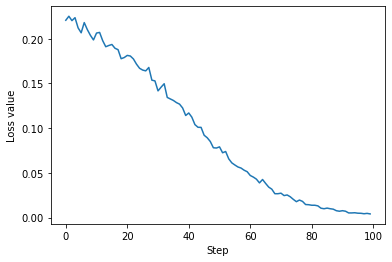

In [17]:
# Theta, phi, lambdaz is the params of u3 gate
theta = np.random.uniform(0, np.pi)
phi = np.random.uniform(0, 2*np.pi)
lambdaz = 0
# Thetas is the param of rz, rx, rz gates
thetas = np.zeros([3,])
sim = Aer.get_backend('qasm_simulator')
number_of_shot = 10000
learning_rate = 0.1
# Calculate loss function in 100 steps
# I confused in this point, is below code right?
ls = []
for i in range(0, 100):
    thetas = thetas - learning_rate*grad_l(thetas)
    qc = construct_circuit(thetas)
    qc_hat = u_thetas_hat(thetas)
    l = 1 - measure(qc)
    ls.append(l)

psi = qi.Statevector.from_instruction(u_3(thetas))
psi_hat = qi.Statevector.from_instruction(qc_hat)
rho_psi = qi.DensityMatrix.from_instruction(u_3(thetas))
rho_psi_hat = qi.DensityMatrix.from_instruction(qc_hat)
print(psi)
print(rho_psi)
print(psi_hat)
print(rho_psi_hat)
# plot_bloch_multivector(psi, title="Psi")
# plot_bloch_multivector(psi_hat, title="Psi_hat")

plt.show()
plt.plot(ls)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()
    

In [50]:
from numpy import linalg as LA
pq = rho_psi - rho_psi_hat
a = np.zeros((2,2), dtype=complex)
a[0][0] = (pq.to_dict())['0|0']
a[0][1] = (pq.to_dict())['0|1']
a[1][0] = (pq.to_dict())['1|0']
a[1][1] = (pq.to_dict())['1|1']
print(rho_psi)
print(rho_psi_hat)
w, v = (LA.eig(a))
print(w)
print(1/2*sum(abs(w)))

DensityMatrix([[ 0.99619175+0.00000000e+00j, -0.05735966-2.24413562e-02j],
               [-0.05735966+2.24413562e-02j,  0.00380825-1.38777878e-17j]],
              dims=(2,))
DensityMatrix([[ 0.79190409+0.j        , -0.34536572+0.21334132j],
               [-0.34536572-0.21334132j,  0.20809591+0.j        ]],
              dims=(2,))
[ 0.42458734-3.15322643e-17j -0.42458734+3.77668868e-18j]
0.4245873411079507
